In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load dataset using ExcelFile
excel_file = pd.ExcelFile(r"/content/final Coal Historical Prices _2020-24.xlsx")

# Read all sheets into DataFrames
dfs = [pd.read_excel(excel_file, sheet_name=sheet_name) for sheet_name in excel_file.sheet_names]

# Merge all sheets into a single DataFrame
df = pd.concat(dfs, ignore_index=True)

# Save the merged DataFrame to a new Excel file (optional)
df.to_excel("merged_file.xlsx", index=False)

# Display the first few rows
print(df.head())

        Date  Coal Richards Bay 4800kcal NAR fob, London close, USD/t  \
0 2020-04-02                                              41.00         
1 2020-04-03                                              40.34         
2 2020-04-06                                              40.34         
3 2020-04-07                                              40.34         
4 2020-04-08                                              40.34         

   Coal Richards Bay 5500kcal NAR fob, London close, USD/t  \
0                                              53.22         
1                                              52.36         
2                                              52.36         
3                                              52.36         
4                                              52.36         

   Coal Richards Bay 5700kcal NAR fob, London close, USD/t  \
0                                               64.7         
1                                               63.1         
2 

In [ ]:
df.isnull().sum()

,0
Date,0
"Coal Richards Bay 4800kcal NAR fob, London close, USD/t",17
"Coal Richards Bay 5500kcal NAR fob, London close, USD/t",17
"Coal Richards Bay 5700kcal NAR fob, London close, USD/t",17
"Coal Richards Bay 6000kcal NAR fob current week avg, No time stamp, USD/t",1
"Coal India 5500kcal NAR cfr, London close, USD/t",17
Natural Gas Price,1
US Crude Oil WTI Prices,1
Non ferrous metal price,26
Dubai Crude Oil,26


In [ ]:
df.columns

Index(['Date', 'Coal Richards Bay 4800kcal NAR fob, London close, USD/t',
       'Coal Richards Bay 5500kcal NAR fob, London close, USD/t',
       'Coal Richards Bay 5700kcal NAR fob, London close, USD/t',
       'Coal Richards Bay 6000kcal NAR fob current week avg, No time stamp, USD/t',
       'Coal India 5500kcal NAR cfr, London close, USD/t', 'Natural Gas Price',
       'US Crude Oil WTI Prices', 'Non ferrous  metal price',
       'Dubai Crude Oil', 'Dutch Natural Gas'],
      dtype='object')

In [ ]:
df.iloc[:, 1:11] = df.iloc[:, 1:11].ffill()
df.isnull().sum()

,0
Date,0
"Coal Richards Bay 4800kcal NAR fob, London close, USD/t",0
"Coal Richards Bay 5500kcal NAR fob, London close, USD/t",0
"Coal Richards Bay 5700kcal NAR fob, London close, USD/t",0
"Coal Richards Bay 6000kcal NAR fob current week avg, No time stamp, USD/t",0
"Coal India 5500kcal NAR cfr, London close, USD/t",0
Natural Gas Price,0
US Crude Oil WTI Prices,0
Non ferrous metal price,0
Dubai Crude Oil,0


In [ ]:
df.duplicated().sum() # Call duplicated() first to get the boolean Series, then apply sum() to it.

np.int64(0)

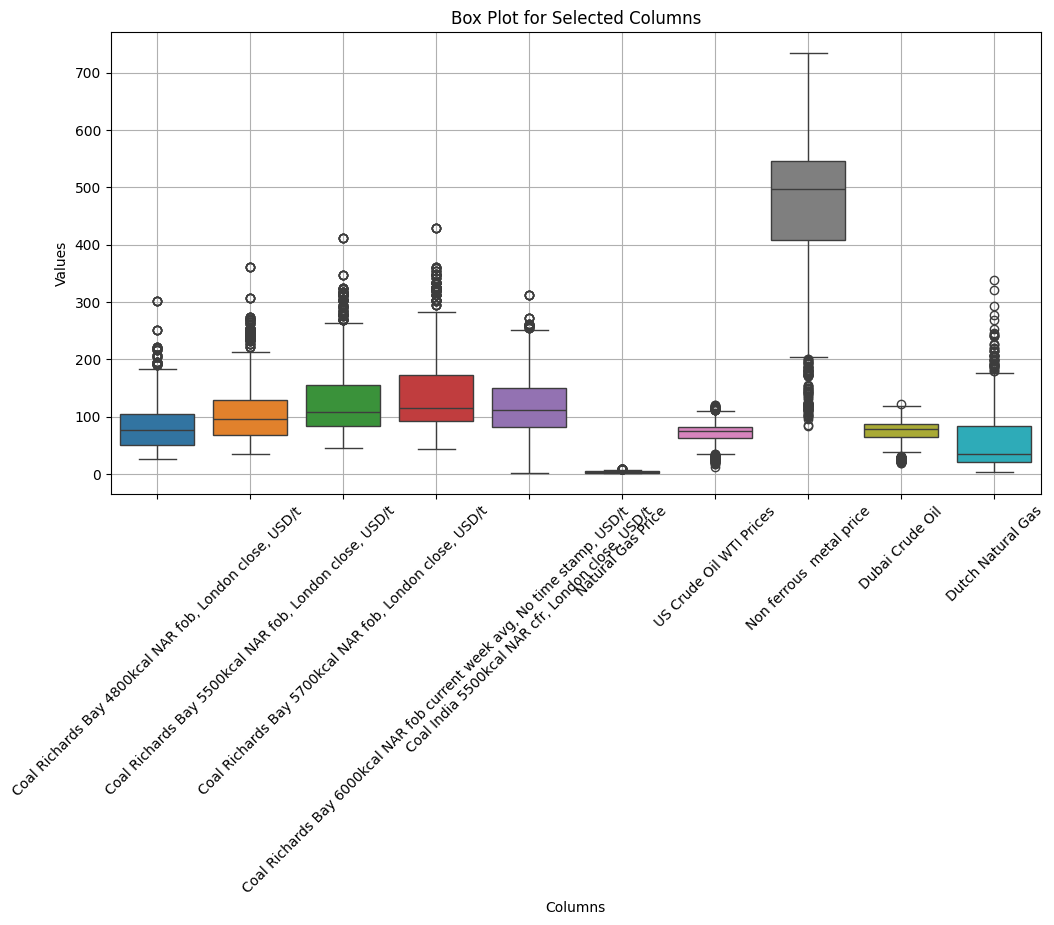

In [ ]:
# Select columns by index (1 to 5)
selected_columns =df.iloc[:, 1:11]  # Index 1 to 5 (Python indexing is zero-based)

# Create box plots for selected columns
plt.figure(figsize=(12, 6))
sns.boxplot(data=selected_columns)
plt.title("Box Plot for Selected Columns")
plt.xlabel("Columns")
plt.ylabel("Values")
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid(True)
plt.show()

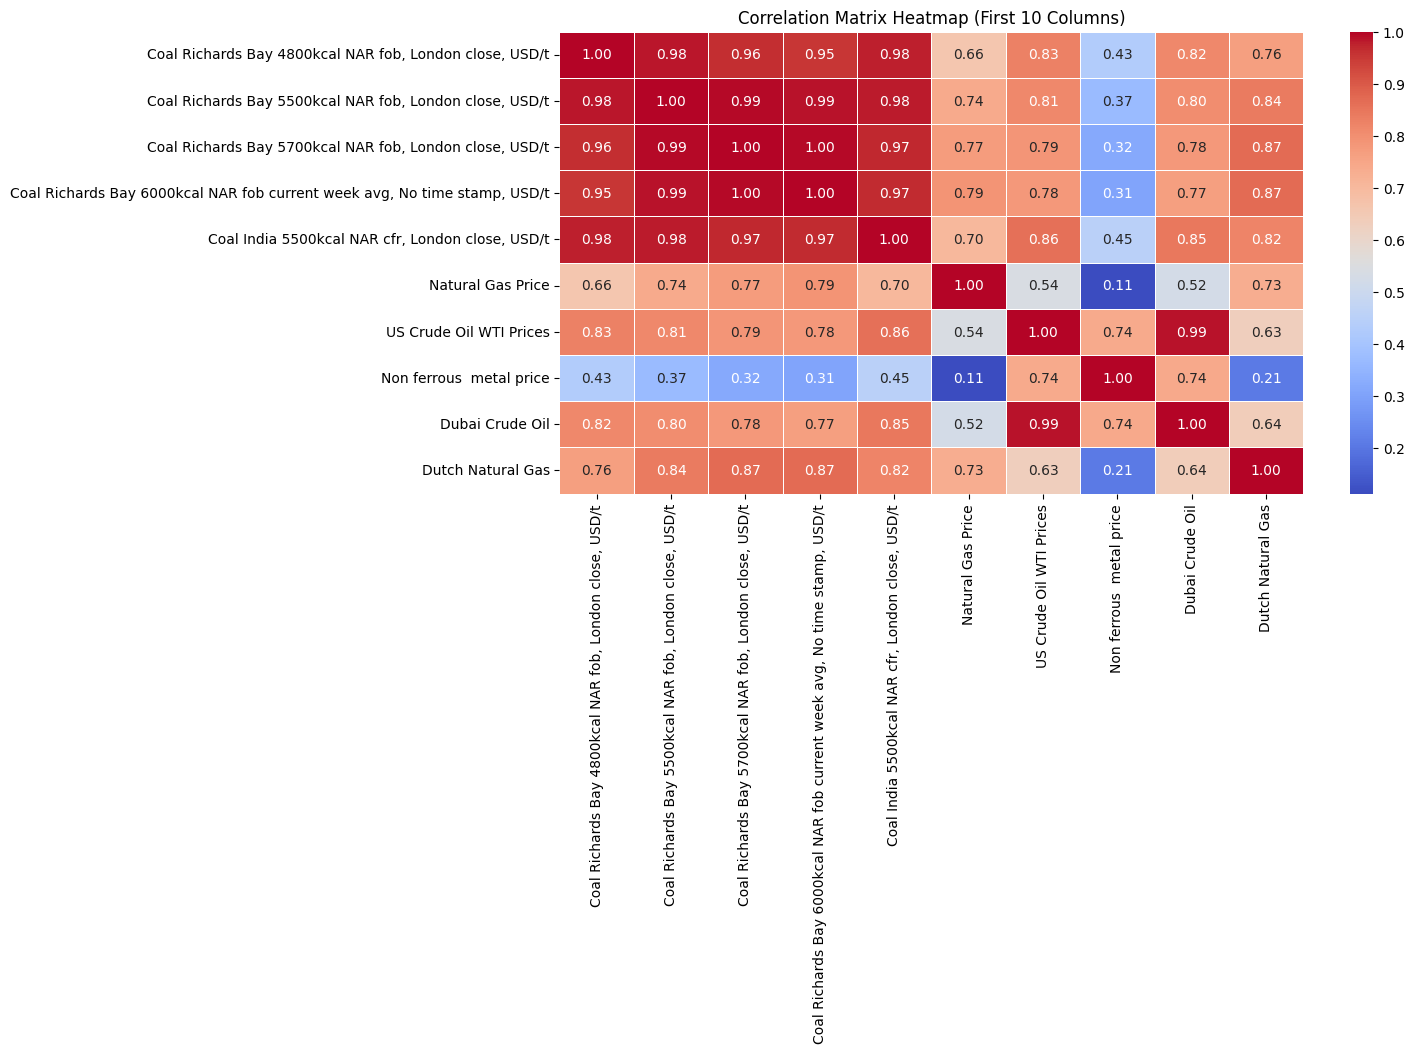

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd  # Ensure pandas is imported

# Compute correlation matrix for the first 10 columns
correlation_matrix = df.iloc[:, 1:11].corr()

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title("Correlation Matrix Heatmap (First 10 Columns)")
plt.show()


In [ ]:
df.drop(['Non ferrous  metal price'],axis=1,inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1085 entries, 0 to 1084
Data columns (total 10 columns):
 #   Column                                                                     Non-Null Count  Dtype         
---  ------                                                                     --------------  -----         
 0   Date                                                                       1085 non-null   datetime64[ns]
 1   Coal Richards Bay 4800kcal NAR fob, London close, USD/t                    1085 non-null   float64       
 2   Coal Richards Bay 5500kcal NAR fob, London close, USD/t                    1085 non-null   float64       
 3   Coal Richards Bay 5700kcal NAR fob, London close, USD/t                    1085 non-null   float64       
 4   Coal Richards Bay 6000kcal NAR fob current week avg, No time stamp, USD/t  1085 non-null   float64       
 5   Coal India 5500kcal NAR cfr, London close, USD/t                           1085 non-null   float64       
 6   

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ------------------------ Step 1: Load & Preprocess Data ------------------------
# Load forecasted external factors
forecasted_df = pd.read_excel("/content/final external factors predictions.xlsx")  # Replace with actual file path

# Convert 'Date' columns to datetime format
df['Date'] = pd.to_datetime(df['Date'])
forecasted_df['Date'] = pd.to_datetime(forecasted_df['Date'])

# Remove future dates from historical data to prevent data leakage
df = df[~df['Date'].isin(forecasted_df['Date'])]  # Keep only past data

# Transform date into numerical format (Days since min date)
df['Days'] = (df['Date'] - df['Date'].min()).dt.days
forecasted_df['Days'] = (forecasted_df['Date'] - df['Date'].min()).dt.days

# Define input features (X)
X = df[['Natural Gas Price', 'US Crude Oil WTI Prices', 'Dubai Crude Oil', 'Dutch Natural Gas', 'Days']]

# Define multiple target variables (coal price columns)
target_columns = [
    'Coal Richards Bay 4800kcal NAR fob, London close, USD/t',
    'Coal Richards Bay 5500kcal NAR fob, London close, USD/t',
    'Coal Richards Bay 5700kcal NAR fob, London close, USD/t',
    'Coal Richards Bay 6000kcal NAR fob current week avg, No time stamp, USD/t',
    'Coal India 5500kcal NAR cfr, London close, USD/t'
]

# Dictionary to store predictions and evaluation metrics
predictions_dict = {}
evaluation_metrics = []

# ------------------------ Step 2: Train & Evaluate Model ------------------------

for target in target_columns:
    print(f"\n🔹 Training Model for: {target}")

    # Define target variable (y)
    y = df[target]

    # Split data into training (80%) and testing (20%)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the Random Forest Regressor model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Predict on train & test sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Compute evaluation metrics
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    # Print metrics
    print(f"   Train R² Score: {train_r2:.4f}, Test R² Score: {test_r2:.4f}")
    print(f"   Train MAE: {train_mae:.2f}, Test MAE: {test_mae:.2f}")

    # Store model predictions
    predictions_dict[target] = y_test_pred

    # Store evaluation metrics
    evaluation_metrics.append({
        "Coal Type": target,
        "Train R² Score": round(train_r2, 4),
        "Test R² Score": round(test_r2, 4),
        "Train MAE": round(train_mae, 4),
        "Test MAE": round(test_mae, 4)
    })

# Convert metrics to DataFrame
metrics_df = pd.DataFrame(evaluation_metrics)


<ipython-input-10-c0bdb31660a1>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Days'] = (df['Date'] - df['Date'].min()).dt.days



🔹 Training Model for: Coal Richards Bay 4800kcal NAR fob, London close, USD/t
   Train R² Score: 0.9954, Test R² Score: 0.9851
   Train MAE: 1.30, Test MAE: 3.26

🔹 Training Model for: Coal Richards Bay 5500kcal NAR fob, London close, USD/t
   Train R² Score: 0.9963, Test R² Score: 0.9811
   Train MAE: 1.59, Test MAE: 4.29

🔹 Training Model for: Coal Richards Bay 5700kcal NAR fob, London close, USD/t
   Train R² Score: 0.9976, Test R² Score: 0.9830
   Train MAE: 1.69, Test MAE: 4.91

🔹 Training Model for: Coal Richards Bay 6000kcal NAR fob current week avg, No time stamp, USD/t
   Train R² Score: 0.9979, Test R² Score: 0.9885
   Train MAE: 1.78, Test MAE: 4.90

🔹 Training Model for: Coal India 5500kcal NAR cfr, London close, USD/t
   Train R² Score: 0.9983, Test R² Score: 0.9908
   Train MAE: 1.03, Test MAE: 2.67


In [ ]:
print(forecasted_df.columns)


Index(['Date', 'Natural Gas Price Forecast',
       'US Crude Oil WTI Prices Forecast', 'Dubai Crude Oil Forecast',
       'Dutch Natural Gas Forecast', 'Days'],
      dtype='object')


In [ ]:
forecasted_df = forecasted_df.rename(columns={
    'Natural Gas Price Forecast': 'Natural Gas Price',
    'US Crude Oil WTI Prices Forecast': 'US Crude Oil WTI Prices',
    'Dubai Crude Oil Forecast': 'Dubai Crude Oil',
    'Dutch Natural Gas Forecast': 'Dutch Natural Gas'
})

In [ ]:

# ------------------------ Step 3: Predict Future Coal Prices ------------------------

# Select forecasted input features
X_forecast = forecasted_df[['Natural Gas Price','US Crude Oil WTI Prices', 'Dubai Crude Oil', 'Dutch Natural Gas', 'Days']]

# Dictionary to store forecasted predictions
forecasted_results = {"Date": forecasted_df["Date"]}

for target in target_columns:
    print(f"\n🔹 Predicting Future Prices for: {target}")

    # Train model again on full historical data
    y = df[target]
    model.fit(X, y)

    # Predict future coal prices
    forecasted_results[target] = model.predict(X_forecast)

# Convert results to DataFrame
forecasted_coal_prices = pd.DataFrame(forecasted_results)

# ------------------------ Step 4: Save Results to CSV ------------------------

# Save test set predictions
predictions_df = pd.DataFrame(predictions_dict)
predictions_df.to_csv("coal_price_predictions.csv", index=False)

# Save evaluation metrics
metrics_df.to_csv("model_evaluation_metrics.csv", index=False)

# Save future predictions
forecasted_coal_prices.to_csv("predicted_coal_prices.csv", index=False)
print("\n✅ All predictions saved to 'coal_price_predictions.csv'")
print("✅ Model evaluation metrics saved to 'model_evaluation_metrics.csv'")
print("✅ Future coal price forecasts saved to 'predicted_coal_prices.csv'")


🔹 Predicting Future Prices for: Coal Richards Bay 4800kcal NAR fob, London close, USD/t

🔹 Predicting Future Prices for: Coal Richards Bay 5500kcal NAR fob, London close, USD/t

🔹 Predicting Future Prices for: Coal Richards Bay 5700kcal NAR fob, London close, USD/t

🔹 Predicting Future Prices for: Coal Richards Bay 6000kcal NAR fob current week avg, No time stamp, USD/t

🔹 Predicting Future Prices for: Coal India 5500kcal NAR cfr, London close, USD/t

✅ All predictions saved to 'coal_price_predictions.csv'
✅ Model evaluation metrics saved to 'model_evaluation_metrics.csv'
✅ Future coal price forecasts saved to 'predicted_coal_prices.csv'
